In [2]:
%pip install numpy
%pip install pandas
%pip install matplotlib
%pip install scikit-learn


import numpy as np
import pandas as pd
from sklearn import naive_bayes 
from sklearn.feature_extraction.text import CountVectorizer
from matplotlib import pyplot as plt

import os 

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
# reading imbd review data from http://ai.stanford.edu/~amaas/data/sentiment/

# not needed can import the dataset as bow rep from keras instead
# reads the .txt files under dir and returns an ndarray of the documents
def read_docs(dir: str) -> np.ndarray:
    try:
        documents = []
        for filepath in sorted(os.listdir(dir), key=lambda name : int(name.split('_')[0])):
            with open(f'{dir}/{filepath}', 'r', encoding='utf8') as txtfile:
                txt = txtfile.read()
                documents.append(txt)
        
        return np.array(documents, dtype=str)

    except FileNotFoundError as e:
        print(f'{e}: unable to read directory {dir}')

x_train = np.concatenate((read_docs('./aclImdb/train/neg'), read_docs('./aclImdb/train/pos')))
vectorizer = CountVectorizer(binary=True, max_features=1000)
vectorizer.fit(x_train)
x_train = vectorizer.transform(x_train).toarray()

# using 0 pos 1 as neg for the classes
y_train = np.concatenate((np.ones(12500), np.zeros(12500)))

x_test = np.concatenate((read_docs('./aclImdb/test/neg'), read_docs('./aclImdb/test/pos')))
x_test = vectorizer.transform(x_test).toarray()

# using 0 pos 1 as neg for the classes
y_test = np.concatenate((np.ones(12500), np.zeros(12500)))



In [4]:
# looking at statistics of the train and test data
print(f'x_train:\n{x_train}\n x_train_dim: {x_train.shape}')
print(f'y_train:\n{y_train}\n y_train_dim: {y_train.shape}')





x_train:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 1 0 0]]
 x_train_dim: (25000, 1000)
y_train:
[1. 1. 1. ... 0. 0. 0.]
 y_train_dim: (25000,)


In [5]:
# train mnb using multinomial naive bayes from sklearn 0.832 accuracy on test data
mnb = naive_bayes.MultinomialNB()
mnb = mnb.fit(x_train, y_train)
yh = mnb.predict(x_test)
acc = mnb.score(x_test, y_test)
print(f'y, yh:\n{y_test.T}, {yh.T}\naccuracy: {acc}')


y, yh:
[1. 1. 1. ... 0. 0. 0.], [1. 1. 1. ... 0. 1. 0.]
accuracy: 0.8322


In [6]:
# implementation for naive bayes from scratch

# multinomial naive bayes model
# using multinomial since features are word frequencies so disecrete but not binary
class multinomial_nb:

    def __init__(self):
        return
    
    # updates self.pi, and self.theta model parameters based on x: features y: labels
    # N: number of examples
    # D: number of features
    # C: number of classes here 2
    # x: N x D 
    # pi: 1/2 since half the documents are pos half are neg in the training
    # theta 2 x D
    def fit(self, x: np.ndarray, y:np.ndarray, a: int=1):
        N, D = x.shape          
        C = int(np.max(y)) + 1
        theta = np.zeros((C, D))
        Nc = np.zeros(C)

        for c in range(C):
            x_c = x[y==c]               # find all rows part of class c
            Nc[c] = x_c.shape[0]        # num elements in x in class c

            # using laplace smoothing so add a to numerator and D to denominator 
            # find the mle of xdc / sum of word counts 
            theta[c, :] = (np.sum(x_c, axis=0) + a)/ (np.sum(x_c) + D)          

        #laplace smoothing (using alpha_c=1 for all c) you can derive using dirichlet's distribution
        self.pi = (Nc+1)/(N+C)                        
        self.theta = theta

        # return mnb to allow . chaining *not important really
        return self

    @staticmethod
    def logsumexp(Z):                                                
        Zmax = np.max(Z,axis=0)[None,:]                                 # dimension C x N 
        log_sum_exp = Zmax + np.log(np.sum(np.exp(Z - Zmax), axis=0))   # max over C
    
        return log_sum_exp
   
    def predict(self, x: np.ndarray) -> np.ndarray:
        N, D = x.shape
        log_prior = np.log(self.pi)
        log_likelihood = x @ np.log(self.theta.T) + (1 - x) @ np.log(1 - self.theta.T)
        log_posterior = log_prior + log_likelihood
        posterior = np.exp(log_posterior - self.logsumexp(log_posterior))
        return np.argmax(posterior, axis=1).reshape(-1, 1)

    @staticmethod
    def accuracy(y:np.ndarray, yh: np.ndarray):
        return yh[yh==y].shape[0] / yh.shape[0]      # acc = num correct entries / num total entries


y, yh:
[[1. 1.]
 [1. 1.]
 [1. 1.]
 ...
 [0. 0.]
 [0. 1.]
 [0. 0.]]
accuracy: 0.762
mnb2.theta loglik:
[[0.00153007 0.00024739 0.00020975 ... 0.00151393 0.00166452 0.00034509]
 [0.00146016 0.0003186  0.00030123 ... 0.00089502 0.00209735 0.00045489]]
min: 6.184801880179772e-05, max: 0.011098582156577672, mean: 0.001


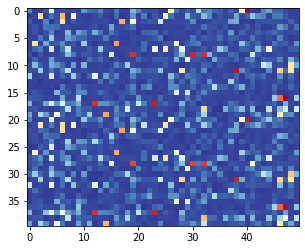

In [7]:
# train mnb classifier using my implementation with 0.762 accuracy on test data
mnb2 = multinomial_nb()

mnb2.fit(x_train, y_train)
yh = mnb2.predict(x_test)
yh = yh.reshape(25000,)
yyh = np.column_stack((y_test, yh))
acc = multinomial_nb.accuracy(y_test, yh)
print(f'y, yh:\n{yyh}\naccuracy: {acc}')

# displaying the log liklihood as a heatmap
fig, ax = plt.subplots()
print(f'mnb2.theta loglik:\n{mnb2.theta}\nmin: {np.min(mnb2.theta)}, max: {np.max(mnb2.theta)}, mean: {np.mean(mnb2.theta)}')
im = ax.imshow(mnb2.theta.reshape((40, 50)), cmap=plt.cm.RdYlBu_r)
fig.savefig('./data/nb_pi_theta_params.png', dpi=400)